In [1]:
%pylab inline

from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
# setting up random seed, it has been set in all helper lib too
np.random.seed(123)

In [3]:
# set path to directories here
poverty_dir = '/datasets/cs255-sp22-a00-public/poverty/'
image_dir = poverty_dir + '/anon_images'
train_table = '../public_tables/train.csv'

In [4]:
# creating main dataframe and image files here
df=pd.read_csv(train_table,index_col=0)
df.index = df['filename']
files=list(glob(f'{image_dir}/*.npz'))

In [ ]:
## Pickled the encoded dataset, so can skip this cell if no changes are being made here (pickle again if Yes)
## Getting features from the images in the main dataframe Enc_data using KD-trees
## Can think of changes here to extract features from the images in a different manner
## max_images = 610 works, but 615 will run out of memory and kernel dies
## try changing the randomness factor here file choosing images to use for encoding
## tree depth: (2^(tree_depth+1))+1 will decide how many columns we will be having in our encoded dataset
## so right now 1024+1 columns will be used to encode the image data as a feature vector
tree_depth = 8
train_size,tree=train_encoder(files,max_images=500,tree_depth=tree_depth)
Enc_data=encoded_dataset(image_dir,df,tree, depth=tree_depth, label_col='label')

In [ ]:
# saving this encoded dataset and tree so that we don't have to encode it every time
# run this cell only if you have made changes to the encoding design
encoded_dataset=f'encoded_dataset.pk'
encoder_tree=f'encoder_tree.pk'
pkl.dump(Enc_data,open(encoded_dataset,'wb'))
pkl.dump(tree, open(encoder_tree,'wb'))

In [5]:
# run this cell to load the encoded dataset and tree 
encoded_dataset=f'encoded_dataset.pk'
encoder_tree = f'encoder_tree.pk'
Enc_data = pkl.load(open(encoded_dataset,'rb'))
tree = pkl.load(open(encoder_tree,'rb'))

In [6]:
# Creating object D to handle dataset functionalities
# like getting subsets, bootstrapping samples, etc
D = DataSplitter(Enc_data.data)

In [7]:
# creating a new metric for our XGBoost algorithm
from sklearn.metrics import f1_score, recall_score

def calc_f1(predt: np.ndarray, dtrain: xgb.DMatrix):
    preds = (predt > 0.5).astype(np.int64)
    res = f1_score(predt>0.5, dtrain.get_label())
    return 'f1', res



In [8]:
# Set all params for XGBoost here
# param dictionary is already present in the lib.XGBoost_Params file
# default parameters are set, can be customized and new params can also be added
param['max_depth'] = 3   # depth of tree
param['eta'] = 0.15      # shrinkage parameter
param['verbosity'] = 0  # 0= no logging 3=max logging
param['feature_selector'] = 'shuffle'
# added parameters from tanmay's part
param['verbose_eval'] = 1 
# param['early_stopping_rounds'] = 15
# param['eval_metric'] = ['auc']
# param['feature_selector'] = 'shuffle'
param['custom_metric'] = calc_f1
param['disable_default_eval_metric']=True


# param['objective'] = 'binary:logistic'
# param['nthread'] = 7 # Number of threads used
param['eval_metric'] = ['error','logloss','auc']
param

{'max_depth': 3,
 'eta': 0.15,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': ['error', 'logloss', 'auc'],
 'feature_selector': 'shuffle',
 'verbose_eval': 1,
 'custom_metric': <function __main__.calc_f1(predt:numpy.ndarray, dtrain:xgboost.core.DMatrix)>,
 'disable_default_eval_metric': True}

In [ ]:
# deciding which rows in dataset to select [True, False, False, True,.....]
train_selector=np.random.rand(df.shape[0]) > 0.35
# subset selecting everything which is True as Train set
Train=D.get_subset(train_selector)
# subset selecting everything which is False as Test set
Test=D.get_subset(~train_selector)

# checking the size of the train and test dataset train should be more
print("Training subset has: ", Train.shape[0], " samples")
print("Testing subset has: ", Test.shape[0], " samples")

In [ ]:
param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=10)

styled_logs=[    
    {   'log':log200,
        'style':['r:','r-'],
        'label':'200 iterations',
        'label_color':'r'
    }
]
_mean,_std=plot_scores(styled_logs,title='All')

pickle_file=f'data/Checkpoint.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



[0]	train-error:0.20852	train-logloss:0.63792	train-auc:0.78984	train-f1:0.00000	eval-error:0.25829	eval-logloss:0.64749	eval-auc:0.70176	eval-f1:0.00000
[1]	train-error:0.19839	train-logloss:0.59517	train-auc:0.82239	train-f1:0.00000	eval-error:0.26698	eval-logloss:0.61345	eval-auc:0.74939	eval-f1:0.00000
[2]	train-error:0.18826	train-logloss:0.56149	train-auc:0.84371	train-f1:0.00000	eval-error:0.26777	eval-logloss:0.58949	eval-auc:0.75936	eval-f1:0.00000
[3]	train-error:0.18163	train-logloss:0.53267	train-auc:0.85468	train-f1:0.01990	eval-error:0.25434	eval-logloss:0.57168	eval-auc:0.75918	eval-f1:0.00530
[4]	train-error:0.17883	train-logloss:0.51057	train-auc:0.86545	train-f1:0.01990	eval-error:0.26224	eval-logloss:0.55664	eval-auc:0.76495	eval-f1:0.00530
[5]	train-error:0.17918	train-logloss:0.49081	train-auc:0.87140	train-f1:0.13753	eval-error:0.26224	eval-logloss:0.54182	eval-auc:0.77938	eval-f1:0.06154
[6]	train-error:0.17464	train-logloss:0.47500	train-auc:0.87569	train-f1:0.1

[53]	train-error:0.08662	train-logloss:0.27548	train-auc:0.96847	train-f1:0.72170	eval-error:0.23697	eval-logloss:0.49217	eval-auc:0.79378	eval-f1:0.40230
[54]	train-error:0.08488	train-logloss:0.27261	train-auc:0.96944	train-f1:0.72670	eval-error:0.23618	eval-logloss:0.49113	eval-auc:0.79499	eval-f1:0.40684
[55]	train-error:0.08488	train-logloss:0.27109	train-auc:0.96983	train-f1:0.73209	eval-error:0.23460	eval-logloss:0.49083	eval-auc:0.79520	eval-f1:0.40304
[56]	train-error:0.08418	train-logloss:0.26989	train-auc:0.97056	train-f1:0.73422	eval-error:0.23697	eval-logloss:0.49105	eval-auc:0.79491	eval-f1:0.40607
[57]	train-error:0.08278	train-logloss:0.26780	train-auc:0.97167	train-f1:0.73856	eval-error:0.24092	eval-logloss:0.49143	eval-auc:0.79448	eval-f1:0.40607
[58]	train-error:0.08208	train-logloss:0.26457	train-auc:0.97254	train-f1:0.74652	eval-error:0.24092	eval-logloss:0.49134	eval-auc:0.79477	eval-f1:0.40762
[59]	train-error:0.07964	train-logloss:0.26332	train-auc:0.97328	train

[106]	train-error:0.04191	train-logloss:0.19035	train-auc:0.99192	train-f1:0.85674	eval-error:0.24013	eval-logloss:0.50725	eval-auc:0.78919	eval-f1:0.41495
[107]	train-error:0.04156	train-logloss:0.18951	train-auc:0.99213	train-f1:0.85918	eval-error:0.24329	eval-logloss:0.50724	eval-auc:0.78934	eval-f1:0.41198
[108]	train-error:0.04191	train-logloss:0.18858	train-auc:0.99235	train-f1:0.86302	eval-error:0.24171	eval-logloss:0.50786	eval-auc:0.78880	eval-f1:0.41276
[109]	train-error:0.04191	train-logloss:0.18761	train-auc:0.99238	train-f1:0.86302	eval-error:0.24013	eval-logloss:0.50740	eval-auc:0.78955	eval-f1:0.41573
[110]	train-error:0.04156	train-logloss:0.18689	train-auc:0.99249	train-f1:0.86302	eval-error:0.24013	eval-logloss:0.50738	eval-auc:0.78977	eval-f1:0.41573
[111]	train-error:0.03842	train-logloss:0.18518	train-auc:0.99292	train-f1:0.86222	eval-error:0.24013	eval-logloss:0.50767	eval-auc:0.79005	eval-f1:0.41573
[112]	train-error:0.03877	train-logloss:0.18313	train-auc:0.9933

[159]	train-error:0.01956	train-logloss:0.13689	train-auc:0.99822	train-f1:0.92958	eval-error:0.23776	eval-logloss:0.52397	eval-auc:0.79014	eval-f1:0.44524
[160]	train-error:0.02026	train-logloss:0.13597	train-auc:0.99826	train-f1:0.93029	eval-error:0.23539	eval-logloss:0.52444	eval-auc:0.79029	eval-f1:0.45196
[161]	train-error:0.01956	train-logloss:0.13557	train-auc:0.99830	train-f1:0.93101	eval-error:0.23539	eval-logloss:0.52506	eval-auc:0.78991	eval-f1:0.45471
[162]	train-error:0.01991	train-logloss:0.13464	train-auc:0.99838	train-f1:0.93101	eval-error:0.23618	eval-logloss:0.52542	eval-auc:0.78956	eval-f1:0.45552
[163]	train-error:0.01921	train-logloss:0.13359	train-auc:0.99845	train-f1:0.93244	eval-error:0.23776	eval-logloss:0.52508	eval-auc:0.79006	eval-f1:0.45826
[164]	train-error:0.01851	train-logloss:0.13292	train-auc:0.99848	train-f1:0.93387	eval-error:0.23934	eval-logloss:0.52608	eval-auc:0.78950	eval-f1:0.45826
[165]	train-error:0.01851	train-logloss:0.13167	train-auc:0.9985

ValueError: ctypes objects containing pointers cannot be pickled

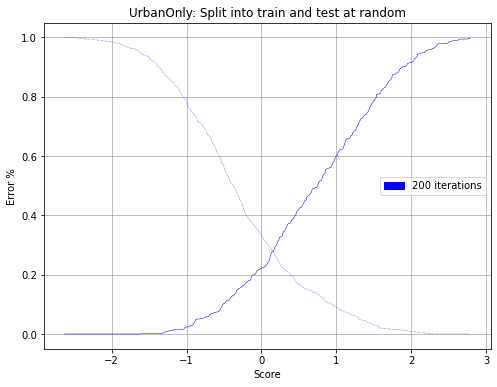

In [9]:
# Only for Urban Areas now
urban=True
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.3
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=1)

styled_logs=[
    {   'log':log200,
        'style':['b:','b-'],
        'label':'200 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Checkpoint_{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



In [ ]:
urban=False
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.3
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log200,
        'style':['b:','b-'],
        'label':'200 iterations',
        'label_color':'b'
    }
]


_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Checkpoint_{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

parameters = {
    # Parameters that we are going to tune.
    'eta':0.15,
    'max_depth': 3,
    'verbosity': 0,
    'nthread': 7,
    'num_rounds': 300,
    'objective':'binary:logistic',
}
gs_xgb, X = log200[-1]['bst'], log200[-1]['dtrain'] 

gridsearch_params = [
    (max_depth, num_rounds, eta/100)
    for max_depth in range(2,4)
    for num_rounds in range(50,250,50)
    for eta in range(10,35,5)
]

min_auc = float("Inf")
best_params = None
for max_depth, num_rounds, eta in gridsearch_params:
    print("CV with max_depth={}, num_rounds={}, eta={}".format(
                             max_depth, num_rounds, eta))
    # Update our parameters
    parameters['max_depth'] = max_depth
    parameters['num_rounds'] = num_rounds
    parameters['eta'] = eta
    
    # Run CV
    cv_results = gs_xgb.cv(
        parameters,
        dtrain,
        nfold=5,
        metrics={'auc','error','logloss'},
        early_stopping_rounds=10
    )
    # Update best MAE
    print(cv_results)
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc < min_auc:
        min_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], min_auc))